In [1]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

So far when explaining how regression works, we've said that it finds the model of best fit by minimizing the squared distance between each datapoint and the line of fit.  Squaring the distance removes concerns about positive vs negative signs, and has a heavier penalty for larger distances.  

The cost function for a linear regression model $y_i = \alpha + \beta x_i$ is:

$$\frac1{n}\sum_{i=1}^n(y_i-(\alpha + \beta x_i))^2$$

where $\alpha + \beta x_i$ is the prediction of the model $\alpha + \beta x$ for predictors $x_i$, $y_i$ is the actual outcome value, and $n$ is the number of distances being summed.

For many linear regressions, the model is sufficiently simple that the true minimum of the cost function can be calculated by solving a system of equations.  However, many other models that we will encounter from this point forward are _too complex_ to be solved for a true minimum.  For those models it's useful to use an iterative algorithm that starts from a random set of parameters and slowly works toward optimizing the cost function.

One such algorithm is **gradient descent**, which iteratively minimizes the cost function using derivatives.  This approach is robust and flexible, and can be applied to basically any differentiable function.

Now we're going to get into the nuts-and-bolts of how gradient descent works (and what differentiable functions are). Hold on to your hats, we're gonna do some calculus!



## Gradient Descent Algorithm

After learning about PCA, you should be comfortable with the idea of data as a multi-dimensional space.  When optimizing a linear regression, the dimensions of the space correspond to the number of parameters in the equation, plus the error function we are trying to minimize.  So a model $y_i = \alpha + \beta x_i$ with two parameters would yield a three-dimensional space.  Within that space is a *surface* made up of all  possible combinations of parameter values, and the error values that result when we plug those parameters into the cost function.  (In a two-dimensional space, we have lines.  In three dimensions and higher, we have surfaces.)

The gradient descent algorithm works iteratively by picking a location on the surface defined by a combination of parameter values, calculating the direction from that point with the steepest 'downhill' gradient, and then moving 'downhill' a set distance.  Then the algorithm picks up the new parameter values of that location on the surface, re-calculates the direction of 'downhill' and moves a set distance again.  The algorithm will repeat this until it finds a location on the surface where all possible gradients away from that location are "uphill": in other words, where all other possible combinations of parameters result in higher error values.  The parameter values that define the location at the lowest point of the space represent the "optimized" solution to the cost function, and are what the regression returns as a solution.

The direction of "downhill" is determined by differentiating the cost function and taking the partial derivative of each parameter of the regression equation.  A function is "differentiable" if a derivative can be calculated at each value of the function.  A derivative, in turn, is a measure of how sensitive a quantity is to change in another quantity.  In other words, if there is a function $f$ that contains parameters $x$ and $y$, the partial derivative for $x$ (expressed as $\frac{\partial}{\partial y}$) will tell us how much $y$ will change for each unit change in $x$.  We could also calculate $\frac{\partial}{\partial x}$, to find out how much a one-unit change in $y$ will impact $x$.

For our two-parameter regression line model, the derivatives are:

$$\frac{\partial}{\partial\alpha} =\frac2n \sum_{i=1}^n - (y^i-(\alpha + \beta x_i) )$$

$$\frac{\partial}{\partial\beta} =\frac2n \sum_{i=1}^n - x_i(y^i-(\alpha + \beta x_i))$$

## Decision-points in Gradient Descent

There are three elements of the gradient descent algorithm that require decisions on the part of the operator.  


### What are the starting values of the parameters?   

Many implementations will start by setting all parameters to zero.  However, this isn't a requirement of the algorithm, and sometimes other starting points may be desirable.


### How far do we "move downhill" after each iteration?

Also called the "learning rate."  A too-small learning rate means the model will be computationally inefficient and take a long time to converge (stop).  A too-large learning rate can result in overshooting the target minimum, resulting in a model that _never_ converges.  Again, most algorithm implementations have pre-determined criteria for setting the learning rate, but these can also be set manually.


### When do we stop?

In the description above, it sounds like the model runs until it reaches the "optimal" solution.  In reality, this isn't computationally efficient.  As the gradient flattens out and we get closer and closer to the minimum value of the error, each iteration of the algorithm will result in a smaller and smaller change in the error.  This can get really slow.  Typically some "minimal acceptable change" is decided on a-priori – once the change in error from iteration n-1 to iteration n is smaller than the threshold, the algorithm stops.  To prevent an algorithm that never stops, there is usually also a maximum number of permitted iterations before the gradient stops, even if it hasn't achieved a change under the threshold.

## Guts of Gradient Descent

Let's walk through programming a gradient descent algorithm in Python.  There are packages that will do this for you, but for now we'll try it from scratch.

## Things Get Messy

Linear regression is a good way to introduce the gradient descent algorithm because there is only one minimum – one absolute best solution.  In other algorithms, however, there may be both a global minimum (the lowest possible value over the entire surface) and many local minima, areas on the surface that are lower than the surface around them.

![local and global minima and maxima](assets/maxima_and_minima.svg)

When using the gradient descent algorithm with models that have local minima the algorithm can get 'caught' in one and converge on a less-than-optimal solution.  One way to avoid this is to run the algorithm multiple times with different starting values.

Still a bit confused? [This](http://www.kdnuggets.com/2017/04/simple-understand-gradient-descent-algorithm.html) is a useful resource for another explanation.

## Stopping rules

In the implementation programmed above, the only stopping rule involves the number of iterations.  As you can see from the plot above, this might be a bit inefficient in this case.  Modify the code above by adding a stopping threshold so that the algorithm stops when the difference in error between two successive iterations is less than .001.  With that rule, how many iterations do you need before you stop?

In [2]:
## Cost function for the linear regression that we will try to optimize.
def LR_cost_function (alpha, beta, x, y):
    '''Return the cost for a given line and data.
    
    Alpha and beta are the coeficients that describe the fit line line, while
    x and y are lists or arrays with the x and y value of each data point.
    '''
    error = 0
    n = len(x)
    for i in range(n):
        point_error = (y[i] - (alpha + beta * x[i])) ** 2
        error += point_error
    return error / n


# Function we'll call each iteration (or step) of the gradient algorithm.
def step (alpha_cur, beta_cur, learning_rate, x, y):
    '''Move downhill from a current cost function to a new, more optimal one.'''
    alpha = 0
    beta = 0
    n = len(x)
    for i in range(n):
        # Partial derivative of the intercept.
        point_alpha = -(2 / n) * (y[i] - ((alpha_cur + beta_cur * x[i])))
        alpha += point_alpha
        
        # Partial derivative of the slope.
        point_beta = -(2 / n) * x[i] * (y[i] - ((alpha_cur + beta_cur * x[i])))
        beta += point_beta
        
    new_alpha = alpha_cur - learning_rate * alpha 
    new_beta = beta_cur - learning_rate * beta
    return [new_alpha, new_beta]

# These constants correspond to the decision-points described above.
# How many steps to take.
stop = 1000

# How far to move with each step.
learning_rate = .005

# Starting values for intercept and slope 
alpha_start = 0
beta_start = 0

# Time to make some data!
x = np.random.normal(0, 1, 100)
y = x * 2 + np.random.sample(100)

# Fit an true minimum regression using solved equations.
regr = linear_model.LinearRegression()
regr.fit(x.reshape(-1, 1), y.reshape(-1, 1))

print('\nCoefficients from sklearn: \n', regr.coef_)
print('\nIntercept from sklearn: \n', regr.intercept_)


# Now fit an iteratively optimized regression using your custom gradient
# descent algorithm.





Coefficients from sklearn: 
 [[2.01683082]]

Intercept from sklearn: 
 [0.44016437]



Coefficients from gradient descent algorithm: 
 2.0167597353921267

Intercept from gradient descent algorithm: 
 0.4400881002576204


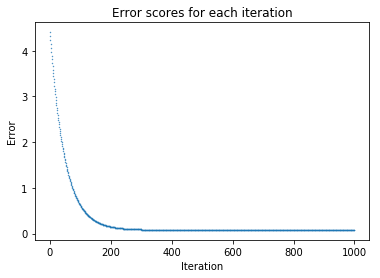

In [3]:
# Storing each iteration to inspect later.
all_error=[]

# Provide starting values.
alpha = alpha_start
beta = beta_start

#Run the algorithm.

for iter in range(stop):
    
    # Take a step, assigning the results of our step function to feed into
    # the next step.
    alpha, beta = step(alpha, beta, learning_rate, x, y)
    
    # Calculate the error.
    error = LR_cost_function(alpha, beta, x, y)                        
    
    # Store the error to instpect later.
    all_error.append(error)

    
print('\nCoefficients from gradient descent algorithm: \n', beta)
print('\nIntercept from gradient descent algorithm: \n', alpha)

plt.plot(all_error, 'o', ms=.4)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error scores for each iteration')
plt.show()


Coefficients from gradient descent algorithm: 
 1.9596301100257456

Intercept from gradient descent algorithm: 
 0.40975044970754776


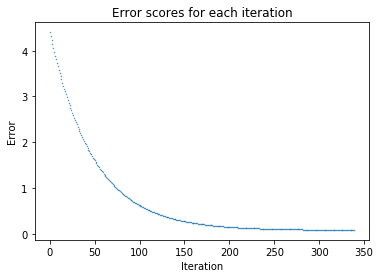

In [4]:
# Storing each iteration to inspect later.
all_error=[]

# Provide starting values.
alpha = alpha_start
beta = beta_start

for iter in range(stop):
    
    # Take a step, assigning the results of our step function to feed into
    # the next step.
    alpha, beta = step(alpha, beta, learning_rate, x, y)
    # Calculate the error.
    error = LR_cost_function(alpha, beta, x, y)                           
    # Store the error to instpect later.
    all_error.append(error)
    
    # ************** stops algorythmn is error diference less than 0.1% *******************************************
    # does not stop on 0 iteration
    if (len(all_error) - 1 ):
        if (all_error[-2] / error) < 1.001: break
    # *************************************************************************************************************
print('\nCoefficients from gradient descent algorithm: \n', beta)
print('\nIntercept from gradient descent algorithm: \n', alpha)

plt.plot(all_error, 'o', ms=.4)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error scores for each iteration')
plt.show()